In [1]:
import torch
import pandas as pd
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import networkx as nx
import ast

In [2]:
en_data = pd.read_csv('en_sent.csv')
es_data = pd.read_csv('es_sent.csv')

In [3]:
def convert_format(field):
    return ast.literal_eval(field)

en_data['hashtags'] = en_data['hashtags'].apply(convert_format)
en_data['links'] = en_data['links'].apply(convert_format)
en_data['mentionedUsers'] = en_data['mentionedUsers'].apply(convert_format)

es_data['hashtags'] = es_data['hashtags'].apply(convert_format)
es_data['links'] = es_data['links'].apply(convert_format)
es_data['mentionedUsers'] = es_data['mentionedUsers'].apply(convert_format)


### 1. Detecting IO Drivers

In [4]:
en_network = pd.read_csv("en_fused_nothing.csv")

In [5]:
es_network = pd.read_csv("es_low_weight_filtered.csv")

In [6]:
top_3_percent_en = int(en_network.shape[0] * 0.03)
top_5_percent_es = int(es_network.shape[0] * 0.05)

# Get the top 5% nodes by eigencentrality
io_drivers_en = en_network.sort_values(by='eigencentrality', ascending=False).head(top_3_percent_en)
io_drivers_es = es_network.sort_values(by='eigencentrality', ascending=False).head(top_5_percent_es)


In [7]:
io_drivers_en.shape

(72, 5)

In [8]:
io_drivers_es.shape

(61, 5)

### 2. Behavioral Analysis

#### 2.1 Basic Stats: common domain, hashtags

In [30]:
from collections import Counter

def get_top_tags(df, data):
    """
    Prints the 10 most common tags in a cluster of nodes.

    Parameters:
    - df: DataFrame representing the cluster, containing user IDs in the 'Id' column.
    - data: DataFrame containing the raw tweet data for the respective language.
    """
    tags = []

    # Iterate over each user in the cluster
    for i, r in df.iterrows():
        user = r['Id'] 
        user_data = data[data['id_str'] == user] 
        
        for _, row in user_data.iterrows():
            hashtags = row['hashtags']
            if isinstance(hashtags, list):
                for tag in hashtags:
                    if 'text' in tag:
                        tags.append(tag['text'].lower())

    print(Counter(tags).most_common(10))
    print(f"Cluster size: {df.shape[0]}")
    print(f"Avg EC: {df['eigencentrality'].mean()}")
    print(f"Max EC: {df.sort_values(by='eigencentrality', ascending=False).head(2)}")


In [32]:
get_top_tags(io_drivers_en, en_data)

[('trump2024', 317), ('biden', 61), ('trump', 49), ('breakingnews', 45), ('nahbabynah', 29), ('fnc', 22), ('jokes', 22), ('politics', 20), ('maga', 19), ('2024election', 17)]
Cluster size: 72
Avg EC: 0.6930036527777779
Max EC:              Id       Label  modularity_class  eigencentrality  Size
163  '14662354'  '14662354'                 6         1.000000    10
190  '25046283'  '25046283'                 6         0.997057    10


In [33]:
get_top_tags(io_drivers_es, es_data)

[('últimahora', 213), ('eu', 159), ('esnoticia', 71), ('trump', 68), ('debate2024', 62), ('opinión', 47), ('elfinancierotv', 46), ('envivo', 39), ('entérate', 37), ('biden', 36)]
Cluster size: 61
Avg EC: 0.6726103114754097
Max EC:              Id        Label  modularity_class  eigencentrality  Size
14   '16676396'   '16676396'                 5         1.000000    10
41  '520653311'  '520653311'                 8         0.984783    10


In [38]:
# Overly general domains to exclude
en_exclude_domains = ["youtu.be", "x.com", "youtube.com", "dlvr.it", "trib.al", "ift.tt", "tiktok.com", "bit.ly", "yahoo.com"]
es_exclude_domains = ["dlvr.it", "youtu.be", "youtube.com", "x.com", "bit.ly", "buff.ly", "ift.tt", "ow.ly", "tinyurl.com", "short.gy", "trib.al", "acortar.link", "uni.vi"]
import tldextract

def extract_base_domain(url):
    extracted = tldextract.extract(url)
    return f"{extracted.domain}.{extracted.suffix}"


def get_top_domains(df, data, exclude_domains):
    """
    Prints the 20 most common domains in a cluster of nodes.

    Parameters:
    - df: DataFrame representing the cluster, containing user IDs in the 'Id' column.
    - data: DataFrame ('en' or 'es' data) containing the raw tweet data for the respective language.
    - exclude_domains: List of domains to exclude from counting.
    """
    domains = []

    # Iterate over each user in the cluster
    for i, r in df.iterrows():
        user = r['Id'] 
        user_data = data[data['id_str'] == user] 
        
        for _, row in user_data.iterrows():
            urls = row['links']
            if isinstance(urls, list):
                for url in urls:
                    if (
                        isinstance(url, dict) and 
                        'expanded_url' in url and 
                        len(url['expanded_url']) > 0
                    ):
                        base_domain = extract_base_domain(url['expanded_url'])
                        if base_domain not in exclude_domains:
                            domains.append(base_domain)

    print(Counter(domains).most_common(20))
    print(f"Cluster size: {df.shape[0]}")
    print(f"Avg EC: {df['eigencentrality'].mean()}")
    print(f"Max EC: {df.sort_values(by='eigencentrality', ascending=False).head(2)}")


In [39]:
get_top_domains(io_drivers_en, en_data, en_exclude_domains)

[('breitbart.com', 82), ('rawstory.com', 63), ('newsweek.com', 46), ('washingtontimes.com', 38), ('foxnews.com', 34), ('mediaite.com', 24), ('usatoday.com', 22), ('newsmax.com', 21), ('nypost.com', 20), ('dailymail.co.uk', 19), ('washingtonexaminer.com', 19), ('conservativebrief.com', 19), ('thepostmillennial.com', 18), ('ow.ly', 17), ('newsbreak.com', 17), ('shr.lc', 14), ('apple.news', 13), ('dailycaller.com', 11), ('google.com', 11), ('tiny.cc', 10)]
Cluster size: 72
Avg EC: 0.6930036527777779
Max EC:              Id       Label  modularity_class  eigencentrality  Size
163  '14662354'  '14662354'                 6         1.000000    10
190  '25046283'  '25046283'                 6         0.997057    10


In [40]:
get_top_domains(io_drivers_es, es_data, es_exclude_domains)

[('infobae.com', 510), ('cnn.it', 444), ('ntn24.com', 313), ('efe.com', 293), ('lopezdoriga.com', 271), ('reforma.com', 270), ('eluniversal.com.mx', 229), ('acento.com.do', 200), ('mldiario.com', 192), ('gaceta.es', 185), ('rtve.es', 184), ('sinembargo.mx', 177), ('excelsior.com.mx', 174), ('notigram.com', 173), ('bitlyanews.com', 164), ('huffingtonpost.es', 153), ('esrt.site', 147), ('dozz.es', 131), ('clarin.com', 128), ('ver.tw', 124)]
Cluster size: 61
Avg EC: 0.6726103114754097
Max EC:              Id        Label  modularity_class  eigencentrality  Size
14   '16676396'   '16676396'                 5         1.000000    10
41  '520653311'  '520653311'                 8         0.984783    10


#### 2.2 engagement indicators (average amount of likes, retweets, replies)

In [9]:
def get_engagement_stats(df, data):
    """
    Calculates and prints the average count of likes, retweets, replies, and quotes.

    Parameters:
    - df: DataFrame representing the cluster, containing user IDs in the 'Id' column.
    - data: DataFrame containing the raw tweet data for the respective language.
    """
    likes = []
    quotes = []
    replies = []
    retweets = []

    # Iterate over each user in the cluster
    for i, r in df.iterrows():
        user = r['Id'] 
        user_data = data[data['id_str'] == user] 
        
        for _, row in user_data.iterrows():
            likes.append(row['likeCount'])
            retweets.append(row['retweetCount'])
            replies.append(row['replyCount'])
            quotes.append(row['quoteCount'])

    # Calculate averages
    avg_likes = sum(likes) / len(likes) if likes else 0
    avg_retweets = sum(retweets) / len(retweets) if retweets else 0
    avg_replies = sum(replies) / len(replies) if replies else 0
    avg_quotes = sum(quotes) / len(quotes) if quotes else 0

    # Print results
    print("Average Engagement Statistics:")
    print(f"Likes: {avg_likes:.2f}")
    print(f"Retweets: {avg_retweets:.2f}")
    print(f"Replies: {avg_replies:.2f}")
    print(f"Quotes: {avg_quotes:.2f}")


In [10]:
get_engagement_stats(io_drivers_en, en_data)

Average Engagement Statistics:
Likes: 28.77
Retweets: 7.28
Replies: 6.32
Quotes: 0.67


In [11]:
get_engagement_stats(io_drivers_es, es_data)

Average Engagement Statistics:
Likes: 28.37
Retweets: 8.56
Replies: 5.33
Quotes: 1.05


#### 2.3 Temporal topical shift

In [25]:
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords

# Download Spanish stopwords
nltk.download('stopwords')
spanish_stopwords = set(stopwords.words('spanish'))

# Combine English and Spanish stopwords
combined_stopwords = list(ENGLISH_STOP_WORDS.union(spanish_stopwords))

# Create a custom CountVectorizer
custom_vectorizer = CountVectorizer(stop_words=combined_stopwords)

# Pass the vectorizer to BERTopic
representation_model = KeyBERTInspired()
topic_model = BERTopic(language="multilingual", vectorizer_model=custom_vectorizer, representation_model=representation_model)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/bowenyi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
def preprocess_and_analyze_topics(cluster_df, data_df):
    """
    Preprocesses data, removes stopwords, and applies BERTopic to analyze topics.
    
    Parameters:
    - cluster_df: DataFrame with cluster information, containing user IDs in the 'Id' column.
    - data_df: DataFrame with raw tweet data, containing 'id_str', 'text', and 'epoch'.
    
    Returns:
    - topic_model: Fitted BERTopic model.
    - topics_df: DataFrame with extracted topics and timestamps.
    """
    # Extract tweets and epochs for users in the cluster
    texts = []
    timestamps = []
    for _, row in cluster_df.iterrows():
        user = row['Id']
        user_data = data_df[data_df['id_str'] == user]
        for _, tweet_row in user_data.iterrows():
            tweet = tweet_row['text']
            if isinstance(tweet, str) and len(tweet) > 0:
                texts.append(tweet)
                timestamps.append(tweet_row['epoch'])

    # Check if texts are non-empty
    if not texts:
        print("No texts available in this cluster.")
        return None, None

    # Set up custom CountVectorizer with stopwords for English and Spanish
    
    topics, probs = topic_model.fit_transform(texts)

    # Create a DataFrame with topics and timestamps
    topics_df = pd.DataFrame({
        'Text': texts,
        'Topic': topics,
        'Timestamp': pd.to_datetime(timestamps, unit='s')  # Convert epoch to datetime
    })

    return topic_model, topics_df

In [29]:
def get_top_topics_per_month(topics_df, topic_model, top_n=5):
    """
    Prints the top N topics for each month.

    Parameters:
    - topics_df: DataFrame containing 'Topic' and 'Timestamp'.
    - topic_model: Fitted BERTopic model.
    - top_n: Number of top topics to display per month.
    """
    # Add a month column for grouping
    topics_df['Month'] = topics_df['Timestamp'].dt.to_period('M')

    # Group by month and calculate topic counts
    grouped = topics_df.groupby(['Month', 'Topic']).size().reset_index(name='Count')

    # Print top N topics for each month
    for month, group in grouped.groupby('Month'):
        print(f"\nTop {top_n} Topics for {month}:")
        top_topics = group.sort_values(by='Count', ascending=False).head(top_n)
        for _, row in top_topics.iterrows():
            topic = row['Topic']
            count = row['Count']
            topic_words = topic_model.get_topic(topic)
            words = ", ".join([word for word, _ in topic_words])
            print(f"Topic {topic} ({count} tweets): {words}")


In [33]:
en_topic_model, en_topics_df = preprocess_and_analyze_topics(io_drivers_en, en_data)

if en_topic_model and en_topics_df is not None:
    get_top_topics_per_month(en_topics_df, en_topic_model, top_n=5)


Top 5 Topics for 2023-05:
Topic -1 (2 tweets): trump, obama, trump2024, presidential, president, democrats, republicans, republican, political, election

Top 5 Topics for 2024-02:
Topic 2 (1 tweets): dude, tyson, guy, legendary, actor, dammit, joe, john, _johnnymaga, bryantejustin

Top 5 Topics for 2024-03:
Topic -1 (1 tweets): trump, obama, trump2024, presidential, president, democrats, republicans, republican, political, election

Top 5 Topics for 2024-05:
Topic -1 (214 tweets): trump, obama, trump2024, presidential, president, democrats, republicans, republican, political, election
Topic 11 (35 tweets): israel, israeli, palestinian, netanyahu, ceasefire, peace, jewish, extremists, political, negotiations
Topic 1 (20 tweets): congresswoman, shes, lady, woman, impeached, nancy, girl, michelle, chick, daughter
Topic 14 (19 tweets): trump, president, sentencing, judge, defendant, presidential, court, testified, trial, convicted
Topic 5 (16 tweets): davidte58841155, kevinadams26, jgalan

In [35]:
es_topic_model, es_topics_df = preprocess_and_analyze_topics(io_drivers_es, es_data)

if es_topic_model and es_topics_df is not None:
    get_top_topics_per_month(es_topics_df, es_topic_model, top_n=5)


Top 5 Topics for 2023-05:
Topic -1 (2 tweets): trump, obama, presidencial, presidente, demócrata, presidenciales, demócratas, netanyahu, presidencia, discurso
Topic 4 (2 tweets): trump, tribunal, judicial, juez, jueza, juicio, condena, demandado, justicia, testigos

Top 5 Topics for 2024-05:
Topic -1 (136 tweets): trump, obama, presidencial, presidente, demócrata, presidenciales, demócratas, netanyahu, presidencia, discurso
Topic 4 (53 tweets): trump, tribunal, judicial, juez, jueza, juicio, condena, demandado, justicia, testigos
Topic 45 (33 tweets): israel, invade, bombas, amenaza, guerra, artillería, munición, ofensivas, armas, advierte
Topic 73 (30 tweets): porno, daniels, actriz, sexuales, sexo, sexual, cárcel, testigo, interrogada, testificando
Topic 103 (23 tweets): testificó, daniels, testimonio, expresidente, testificar, revelación, porno, quejó, describió, sexual

Top 5 Topics for 2024-06:
Topic -1 (292 tweets): trump, obama, presidencial, presidente, demócrata, presidencial

In [39]:
def print_top_topics(cluster_df, data_df):
    """
    Extracts and prints the top 10 topics by frequency for a cluster of tweets.

    Parameters:
    - cluster_df: DataFrame representing the cluster, containing user IDs in the 'Id' column.
    - data_df: DataFrame containing raw tweet data, with user IDs in 'id_str' and tweets in 'text'.
    """
    # Extract tweets for users in the cluster
    texts = []
    for _, row in cluster_df.iterrows():
        user = row['Id']
        user_data = data_df[data_df['id_str'] == user]
        
        for _, tweet_row in user_data.iterrows():
            tweet = tweet_row['text']
            if isinstance(tweet, str) and len(tweet) > 0:
                texts.append(tweet)

    # Check if texts are non-empty
    if not texts:
        print("No texts available in this cluster.")
        return

    # Apply BERTopic
    topics, probs = topic_model.fit_transform(texts)

    # Get topic frequencies
    topic_freq = topic_model.get_topic_freq().head(11)  # Exclude topic -1 if present

    # Print the top 10 topics
    print("Top 10 Topics by Frequency:")
    for _, row in topic_freq.iterrows():
        topic_id = row['Topic']
        if topic_id == -1:
            continue  # Skip outlier topic
        topic_words = topic_model.get_topic(topic_id)
        print(f"Topic {topic_id}: {', '.join([word for word, _ in topic_words])} (Frequency: {row['Count']})")

In [40]:
topic_model_en, topics_df_en = print_top_topics(io_drivers_en, en_data)


Top 10 Topics by Frequency:
Topic 0: democrats, presidential, president, democratic, candidate, republicans, nominee, trump, election, campaign (Frequency: 560)
Topic 1: congresswoman, shes, lady, woman, michelle, chick, person, names, speaks, kidding (Frequency: 211)
Topic 2: dammit, dumbshit, damn, guy, tyson, maddenifico, joe, _johnnymaga, bryantejustin, john (Frequency: 195)
Topic 3: kerosi__, welcome, jenresistedagn, congrats, jeremys26458973, hskaarup1, jocelynjtweet, michaelianblack, awesome, marievolland1 (Frequency: 182)
Topic 4: trump, trumpwarroom, trump2024, president, google, maga, disappointed, politically, diddy, campaign (Frequency: 169)
Topic 5: democrat, democrats, candidate, bid, senator, election, republican, democratic, nominee, republicans (Frequency: 164)
Topic 6: mediabias, spokesman, reporter, joe, kenny, press, media, news, whine, biden (Frequency: 156)
Topic 7: maga, lol, loony, lidiauly9g, offends, ixqohhod9t, oh, libtard, fuck, hutj2etddh (Frequency: 154)
T

TypeError: cannot unpack non-iterable NoneType object

In [41]:
topic_model_es, topics_df_es = print_top_topics(io_drivers_es, es_data)


Top 10 Topics by Frequency:
Topic 0: demócrata, demócratas, candidata, presidencial, obama, presidencia, presidenta, vicepresidenta, elecciones, campaña (Frequency: 340)
Topic 1: demócrata, demócratas, votar, delegados, presidenciales, candidata, votos, elecciones, presidencial, presidencia (Frequency: 274)
Topic 2: electoral, elecciones, renuncia, presidencial, renunciar, campaña, abandonará, retirará, candidatura, renuncie (Frequency: 208)
Topic 3: acusado, condenado, biden, jurado, hijo, condena, judicial, culpable, juez, hunter (Frequency: 205)
Topic 4: vladimir, kremlin, rusia, ruso, rusas, rusa, moscú, ucrania, ucranianos, ucraniano (Frequency: 195)
Topic 5: trump, tribunal, judicial, juez, jueza, juicio, condena, demandado, justicia, testigos (Frequency: 155)
Topic 6: delegación, méxico, embajador, dama, jill, acompañarán, presidenta, presidente, biden, claudia (Frequency: 135)
Topic 7: mexicano, mexicanos, méxico, trump, presidenta, presidente, presidencia, cubanos, narcotráfic

TypeError: cannot unpack non-iterable NoneType object

In [42]:
en_data

,id,text,lang,epoch,hashtags,links,replyCount,retweetCount,likeCount,quoteCount,conversationId,mentionedUsers,id_str,followersCount,friendsCount,statusesCount,sentiment
0,1.800878e+18,If we say MAGA is a cult we have to include th...,en,1.718198e+09,[],[],0.0,0.0,0.0,0.0,1.800868e+18,[],'180970841',283,1081,3584,2
1,1.800863e+18,@Bubblebathgirl Which means absolutely nothing...,en,1.718194e+09,[],[],0.0,0.0,0.0,0.0,1.800514e+18,"[{'id_str': '32804484', 'name': 'Paul A. Szypu...",'60090450',239,667,8161,1
2,1.800889e+18,@simonateba Harvard has really lost it.,en,1.718200e+09,[],[],0.0,0.0,0.0,0.0,1.800888e+18,"[{'id_str': '130003441', 'name': 'Simon Ateba'...",'156726345',13446,10976,35518,2
3,1.800871e+18,@Sportz_DC Good God almighty! When did the con...,en,1.718196e+09,[],[],1.0,0.0,5.0,0.0,1.800849e+18,"[{'id_str': '1496643443879198720', 'name': 'Va...",'1425183551511740419',552,264,11669,0
4,1.800875e+18,"@cspanwj @RepHankJohnson Pep Johnson, does Con...",en,1.718197e+09,[],[],0.0,0.0,1.0,0.0,1.800869e+18,"[{'id_str': '15923226', 'name': 'Washington Jo...",'1513631239319822344',428,248,23459,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
588834,1.836602e+18,@kevin_smith45 And they weren't bussed in paid...,en,1.726715e+09,"[{'indices': [74, 84], 'text': 'Trump2024'}]",[],0.0,0.0,0.0,0.0,1.836425e+18,"[{'id_str': '1921810315', 'name': 'kevin smith...",'1369668425992318986',304,536,19319,2
588835,1.836618e+18,"Nearly 530,000 migrants came to US 'legally,' ...",en,1.726719e+09,"[{'indices': [125, 133], 'text': 'FoxNews'}]",[{'display_url': 'foxnews.com/us/nearly-5300…'...,0.0,1.0,0.0,0.0,1.836618e+18,[],'1547768887474737152',9529,7024,324691,2
588836,1.836571e+18,@sgaut @Inskigator @BehizyTweets @DadOfBS You ...,en,1.726708e+09,[],[],1.0,0.0,4.0,0.0,1.836532e+18,"[{'id_str': '29509675', 'name': 'SGaut', 'scre...",'1771011663820734464',263,92,3211,2
588837,1.836574e+18,@SarahIronside6 Interests rates still far abov...,en,1.726708e+09,[],[],0.0,0.0,0.0,0.0,1.836472e+18,"[{'id_str': '1325874154059554816', 'name': 'Sa...",'23216533',679,1172,9141,0


#### 2.4 Sentiment shift over time

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_sentiment_evolvement(cluster_df, data_df, lang):
    """
    Visualizes the evolution of sentiment over time for a specific cluster.

    Parameters:
    - cluster_df: DataFrame representing the cluster, containing user IDs in the 'Id' column.
    - data_df: DataFrame containing raw tweet data with 'id_str', 'epoch', and 'sentiment'.
    - lang: String indicating the language ('English' or 'Spanish').
    """
    tweets = []
    for _, row in cluster_df.iterrows():
        user = row['Id']
        user_data = data_df[data_df['id_str'] == user]
        tweets.append(user_data[['epoch', 'sentiment']])
    
    # Combine into a single DataFrame
    sentiment_df = pd.concat(tweets)
    sentiment_df['Timestamp'] = pd.to_datetime(sentiment_df['epoch'], unit='s')  # Convert epoch to datetime
    sentiment_df['Date'] = sentiment_df['Timestamp'].dt.date  # Extract date

    # Aggregate sentiment counts by date
    sentiment_counts = sentiment_df.groupby(['Date', 'sentiment']).size().reset_index(name='Count')

    # Convert 'sentiment' to categorical type with specified order
    sentiment_order = [0, 1, 2]  # Assuming 0: Negative, 1: Neutral, 2: Positive
    sentiment_counts['sentiment'] = pd.Categorical(sentiment_counts['sentiment'], categories=sentiment_order, ordered=True)

    # Define a custom color palette for sentiment
    sentiment_palette = {
        0: 'red',     # Negative sentiment
        1: 'blue',    # Neutral sentiment
        2: 'green'    # Positive sentiment
    }

    # Plot
    plt.figure(figsize=(14, 8))
    sns.lineplot(data=sentiment_counts, x='Date', y='Count', hue='sentiment', hue_order=sentiment_order, palette=sentiment_palette)
    plt.title(f"Sentiment Evolvement Over Time ({lang})", fontsize=16)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel("Count of Tweets", fontsize=14)
    plt.grid(True)

    # Create a custom legend
    custom_legend = [
        Line2D([0], [0], color='red', lw=2, label='Negative (0)'),
        Line2D([0], [0], color='blue', lw=2, label='Neutral (1)'),
        Line2D([0], [0], color='green', lw=2, label='Positive (2)')
    ]
    plt.legend(handles=custom_legend, title="Sentiment")

    # Save the figure
    plt.savefig(f"{lang}_sentiment_fixed.png", bbox_inches='tight', dpi=300)

    plt.show()


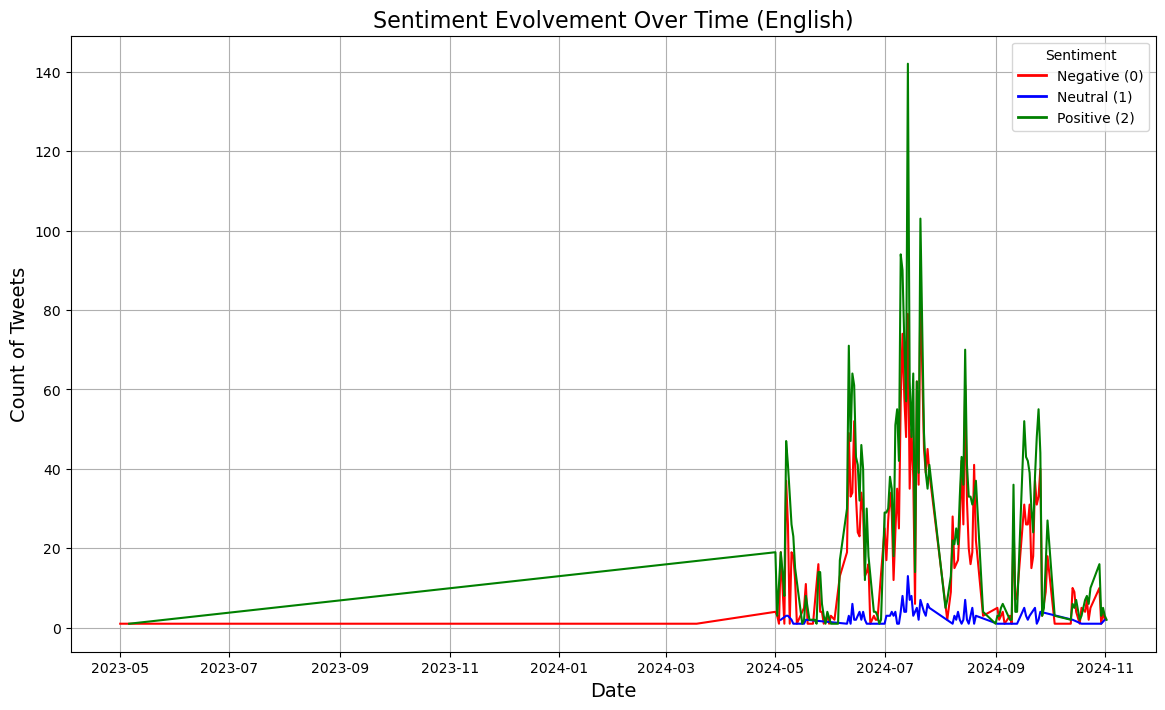

In [68]:
visualize_sentiment_evolvement(io_drivers_en,en_data,'English')

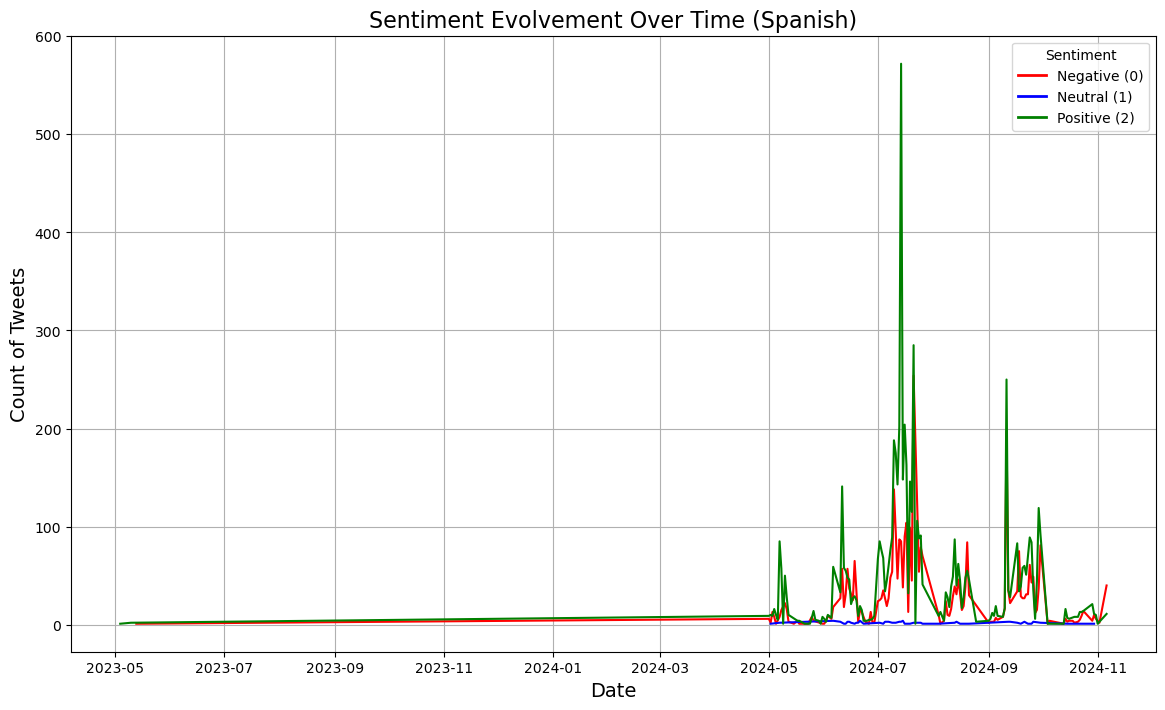

In [69]:
visualize_sentiment_evolvement(io_drivers_es,es_data,'Spanish')